<div id="BBox" class="alert alert-success">
    <h1 style="font-family:verdana;color:black;">Problem Statement</h1>
    <p style="font-family:courier;color:black;">
        <strong> You are given a dataset of users and their rating against few learning units. Taking this dataset into account, you need to design a recommendation system that would suggest the leanring units for the new users (not have any previous records).</strong>
    </p>
    <p style="font-family:courier;color:black;"><strong> Further Details </strong> </p>
    <span style="font-family:courier;color:black;">
        <ol>
          <li>Learning Unit matrix containing the user's feedback on various Learning Units.</li>
            <ol type="a">
              <li>Here each column represents the rating a user has given for a learning unit</li>
              <li>User identifier is email id</li>
              <li>You will see NA when a user has not rated a learning unit.</li>
            </ol>
          <li>User profile matrix that contains the information about some existing users</li>
          <li>User profile details of some future users for whom you want to recommend Learning Units.</li>
        </ol> 
   <p style="font-family:courier;color:black;"><strong> Challenge </strong></p>
   <span style="font-family:courier;color:black;"> Analyze the above dataset (sheet #1 & #2) and design a Recommender system which will recommend 5 LUs (ranked) for each of the future user listed in the Sheet number 3. </span>
<div>

In [20]:
import pandas as pd # for data structure and analysis
import numpy as np# for data structure and analysis for data structure and linear algebra
from scipy.sparse import csr_matrix # for removing sparsity from the data
from sklearn.neighbors import NearestNeighbors # for KNN (ML library)
import matplotlib.pyplot as plt # for data visualization
import seaborn as sns # for data visualization

<div id="BBox" class="alert alert-info">
    <h3 style="font-family:verdana;color:black;">Reading and analysing dataset </h3>
    <span style="font-family:courier;color:black;">
        <ol>
          <li>Reading the XL file and different sheets to load the data into the memory and to create the pandas dataframe for further analysis.</li>
          <li>The below tables shows the unique number of industries, positions, departments and job title with respect to all users. This helps us to understand the user similairy and their background.</li>
<!--           <li>User profile details of some future users for whom you want to recommend Learning Units.</li> -->
        </ol>
    </span>
<div>

In [21]:
# Reading the dataset
file_name = "Dataset.xlsx"
# Reading the rating sheet
rating_df = pd.read_excel(file_name, sheet_name="LU Rating Matrix")

# Reading the user profile sheet
user_df = pd.read_excel(file_name, sheet_name="User Profile Matrix")

# Reading the test sheet
test_df = pd.read_excel(file_name, sheet_name="Q")

users = user_df["Username"].values
industry = user_df['Industry'].values
position = user_df['Position'].values
department = user_df['Department'].values
test_samples = test_df.values
user_df.describe()

,Username,Job Title,Industry,Position,Department
count,43,43,43,43,43
unique,43,29,4,2,4
top,maria.franke@peers-solutions.com,Kommunikationsmanager/Kommunikationsmanagerin,"Finanzen, Versicherungen & Immobilien",Employee,Vertrieb
freq,1,5,12,22,13


In [22]:
# unique_industry = list(set(industry))
# unique_positions = list(set(position))
# unique_department = list(set(department))
# Set operations suffle the index, to make it constant we defined the unique industry, positions and departments
unique_industry = ['Finanzen, Versicherungen & Immobilien', 'Handel', 'Energie & Umwelt', 'Metall & Elektronik']
unique_positions = ['Employee', 'Manager']
unique_department = ['Marketing', 'Produktion', 'Vertrieb', 'Personalwesen']
# print(unique_industry,unique_positions,unique_department)
print("Number of unique (industry,position,department):",len(unique_industry),len(unique_positions),len(unique_department))

Number of unique (industry,position,department): 4 2 4


<div id="BBox" class="alert alert-info">
    <h3 style="font-family:verdana;color:black;">Transforming user information to categorial variables</h3>
    <span style="font-family:courier;color:black;">
        <ol>
          <li>We selected only three fields [industry, position and department] to group the user who have similar background.</li>
          <li>Further, converted these three fields into the categorical variable.</li>
          <li>We believe that if the user shares the same department, industry and the position, it is more likely that they would have the same career prospective. Hence would be interested into the similar learning units.</li>
        </ol>
    </span>
<div>

In [23]:
data = []
for i in range(len(users)):
    industry_id = unique_industry.index(industry[i])+1
    position_id = unique_positions.index(position[i])+1
    department_id = unique_department.index(department[i])+1
    # Appending these ids into the list
    data.append([industry_id,position_id,department_id])
    
data = np.array(data)
print("Data shape:",data.shape)

Data shape: (43, 3)


<div id="BBox" class="alert alert-info">
    <h3 style="font-family:verdana;color:black;">Visualizing Training and Test User Profiles</h3>
    <span style="font-family:courier;color:black;">
        <ol>
          <li>We created a 3D scatter plot to see how user's background is positioned with respect to each other. The red dots are represeting the user in the 3D space, while the number represents the user id. For example user "maria.franke@peers-solutions.com" has user id "1", user "melanie.krahl@peers-solutions.com" has user id "2" and so on.</li>
          <li>We can see a overlap on red dots and the numbers, this shows that two users shares the same industry, position and department. </li>
          <li> The test users (who are not enrolled in the system) is represented by green square.</li>
          <li> For the test users, if they don't fall into the existing industries, positions and departements then we use 0, rather than assigning the respective value. </li>
        </ol>
    </span>
<div>

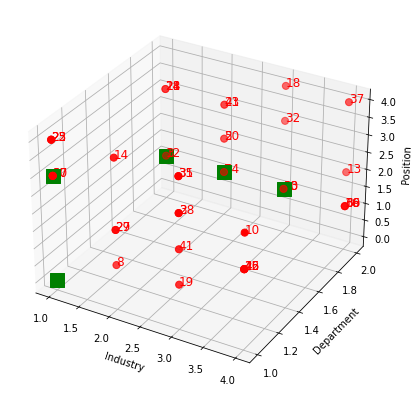

In [24]:
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(projection='3d')

xs = data[:,0]
ys = data[:,1]
zs = data[:,2]
ax.scatter(xs, ys, zs, marker='o', color='r',s=50)

test_user_info = []
for i in range(test_df.shape[0]):
    # print(test_samples[i][2],test_samples[i][3],test_samples[i][4])
    try:
        ind_id = unique_industry.index(test_samples[i][2])+1
    except:
        ind_id = 0
    try:
        pos_id = unique_positions.index(test_samples[i][3])+1
    except:
        pos_id = 0
    try:
        dep_id = unique_department.index(test_samples[i][4])+1
    except:
        dep_id = 0
    test_vector = [ind_id, pos_id, dep_id]
    test_user_info.append(test_vector)
    test_vector = np.array(test_vector)
    # print(test_vector)
    ax.scatter(test_vector[0], test_vector[1], test_vector[2], marker='s',color='g',s=200)

for i in range(len(users)):
    txt = str(i+1)
    ax.text(data[i][0],data[i][1],data[i][2], txt, color='red',fontsize=12)
ax.set_xlabel('Industry')
ax.set_ylabel('Department')
ax.set_zlabel('Position')

plt.show()

<div id="BBox" class="alert alert-info">
    <h3 style="font-family:verdana;color:black;">Finding similarity between test users and enrolled users</h3>
    <span style="font-family:courier;color:black;">
        <ol>
          <li>We used cosine similarity to find the angle between two vectors, if the distance is close to 0, it means both the vector and close while if the angle is close to 90 then its far.</li>
          <li>We selected the minimum angle among the test vector and the train vectors (existing user) to find the right match (similar user).</li>
          <li> We found the below similar users between the test and train set. </li>
             <ol type="a">
              <li>"Franke" is close to ['helga.winter@peers-solutions.com', 'jacob.reinhart@peers-solutions.com', 'kathrin.eichberg@peers-solutions.com', 'gregor.hantzsch@peers-solutions.com', 'julian.lehmann@peers-solutions.com', 'swen.rieger@peers-solutions.com'] with angle "0.0"</li>
              <li>"Marie" is close to ['angelika.ribbentrop@peers-solutions.com', 'josephine.moldenhauer@peers-solutions.com'] with angle "0.055"</li>
              <li>"Agnes" cis close to ['maria.franke@peers-solutions.com', 'leonie.brandt@example.com', 'karla.edelstein@peers-solutions.com', 'luka.simon@peers-solutions.com'] with angle "0.0"</li>
              <li>"David" cis close to ['stephan.herrmann@peers-solutions.com', 'klemens.faas@peers-solutions.com'] with angle "0.0"</li>
              <li>"Bärbel" cis close to ['lotte.haushofer@peers-solutions.com', 'alice.werner@peers-solutions.com'] with angle "0.0"</li>
            </ol>
        </ol>
    </span>
<div>

In [25]:
test_user_info = np.array(test_user_info)
print("Number of test users:",test_user_info.shape[0])
similar_users = []
for test_id, test_user in enumerate(test_user_info):
    angles = []
    for train_user in data:
        
        d = 1 - round(np.dot(test_user, train_user)/(np.linalg.norm(test_user)*np.linalg.norm(train_user)),3)
        # d = round(distance.hamming(test_user,train_user),3)
        angles.append(d)
        # print(test_user,train_user,round(d,3))
    
    # Finding out the minimum distance (angle)
    min_dist = min(angles)
    result = [index+1 for index in np.where(angles == min_dist)[0]] # added one becaouse user id start from 1
    selected_users = [users[index-1] for index in result] # remove 1 as index starts from 0
    print(test_df['Username'][test_id],min_dist,selected_users)
    similar_users.append(result)

Number of test users: 5
Franke 0.0 ['helga.winter@peers-solutions.com', 'kathrin.eichberg@peers-solutions.com']
Marie 0.05500000000000005 ['lotte.haushofer@peers-solutions.com', 'alice.werner@peers-solutions.com']
Agnes 0.0 ['maria.franke@peers-solutions.com', 'leonie.brandt@example.com', 'karla.edelstein@peers-solutions.com', 'luka.simon@peers-solutions.com']
David 0.0 ['stephan.herrmann@peers-solutions.com', 'klemens.faas@peers-solutions.com']
Bärbel 0.0 ['lotte.haushofer@peers-solutions.com', 'alice.werner@peers-solutions.com']


<div id="BBox" class="alert alert-warning">
    <h3 style="font-family:verdana;color:black;">Designing a recommendation system for existing users</h3>
    <span style="font-family:courier;color:black;">
        We have many missing values for the learning uints, represented a Nan values (please see the below table). We are going to train our system to predict the rating for those missing training units. The idea is to generate more rating so that once we select the user's pool (the similar users) we can utilize these training units for the better recommendation to the test users.     </span>
<div>

In [26]:
profiles = rating_df['Course Name'].values
print("Number of courses:",len(profiles))
unique_profiles = list(set(profiles))
print("Number of unique courses:",len(unique_profiles))
user_names = user_df['Username'].values

Number of courses: 122
Number of unique courses: 121


In [27]:
user_df.head(4)
user_dict = {}
for i,user_name in enumerate(user_names):
    user_dict[user_name] = i

In [28]:
rating_df.head(4)

,Course Name,maria.franke@peers-solutions.com,melanie.krahl@peers-solutions.com,helga.winter@peers-solutions.com,jacob.reinhart@peers-solutions.com,angelika.ribbentrop@peers-solutions.com,phillipp.dahn@peers-solutions.com,stephan.herrmann@peers-solutions.com,hella.emmerich@peers-solutions.com,leonie.brandt@example.com,...,klemens.faas@peers-solutions.com,anne.bergmann@peers-solutions.com,kali.graham@peers-solutions.com,georg.bödeker@peers-solutions.com,johan.thierse@peers-solutions.com,michaela.alt@peers-solutions.com,luka.simon@peers-solutions.com,marko.thomas@peers-solutions.com,swen.rieger@peers-solutions.com,fabiane.maibaum@peers-solutions.com
0,Practical knowledge leadership,NaN,NaN,NaN,2.5,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Social Media Guidelines online course,2.5,NaN,1.5,NaN,NaN,3.5,NaN,NaN,NaN,...,2.5,NaN,NaN,2.5,2.5,1.0,5.0,2.5,4.5,NaN
2,Healthy work in the office: accident prevention,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Healthy work on the screen workstation,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<div id="BBox" class="alert alert-warning">
    <h3 style="font-family:verdana;color:black;">Transforming the dataframe for better visualization and access </h3>
    <span style="font-family:courier;color:black;">
     We assigned a course id for every leanring unit and and the uer id for each user.
    </span>
<div>

In [29]:
dict = {}
course_dict = {}
for i in range(len(profiles)):
    course_dict[profiles[i]]=i

for i,column_name in enumerate(rating_df.columns):
    if i==0:
        dict['Course Name'] = 'Course ID'
    else:
         dict[column_name] = i

# call rename () method
rating_df.rename(columns=dict,inplace=True)
rating_df['Course ID'] = [i+1 for i in range(len(profiles))]
rating_df.head(4)

,Course ID,1,2,3,4,5,6,7,8,9,...,34,35,36,37,38,39,40,41,42,43
0,1,NaN,NaN,NaN,2.5,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2.5,NaN,1.5,NaN,NaN,3.5,NaN,NaN,NaN,...,2.5,NaN,NaN,2.5,2.5,1.0,5.0,2.5,4.5,NaN
2,3,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<div id="BBox" class="alert alert-warning">
    <h3 style="font-family:verdana;color:black;">Replacing the Nan values with 0 </h3>
    <span style="font-family:courier;color:black;">
     The intersection of row and column shows the rating of the leanring unit given by that user. For example user-1 has given 2.5 rating for the course-2. The Nan values are representing that the rating has not given by that user for that particular leanring unit.
    </span>
<div>

In [30]:
rating_df.fillna(0,inplace=True)
rating_df.head(10)

,Course ID,1,2,3,4,5,6,7,8,9,...,34,35,36,37,38,39,40,41,42,43
0,1,0.0,0.0,0.0,2.5,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,2.5,0.0,1.5,0.0,0.0,3.5,0.0,0.0,0.0,...,2.5,0.0,0.0,2.5,2.5,1.0,5.0,2.5,4.5,0.0
2,3,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,0.0,0.0,0.0,4.0,4.0,0.0,2.0,1.5,1.0,...,0.0,2.0,4.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
6,7,3.5,2.5,3.5,0.0,0.0,4.0,0.0,0.0,0.0,...,1.5,0.0,0.0,2.5,4.0,1.5,4.5,1.0,2.5,0.0
7,8,0.0,0.0,0.0,0.0,0.0,4.5,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,9,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,...,1.0,4.5,2.0,2.0,4.5,4.0,3.0,1.0,1.0,0.0
9,10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.5


<div id="BBox" class="alert alert-warning">
    <h3 style="font-family:verdana;color:black;">Applying KNN to find the similar leanring units </h3>
    <span style="font-family:courier;color:black;"> We apply K-Nearest Neighbour to find the similar courses/learning units. In order to build the model, we need to decide over number of neighbours and the distance metric. we defined neighbours as 5 and the distance as "cosine". Further we used "Compressed Sparse Row matrix" to remove sparsity from the dataset and fast matrix vector products. 
    </span>
<div>

In [31]:
csr_data = csr_matrix(rating_df.values)
knn = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=5, n_jobs=-1)
knn.fit(csr_data)

course_name = "Sales tax current"
n_courses_to_reccomend =5

course_id = course_dict[course_name]
index_for_course = rating_df.index.tolist().index(course_id)

distances , indices = knn.kneighbors(csr_data[index_for_course],n_neighbors=n_courses_to_reccomend+1)  
distances = distances[0]
indices =  indices[0]


closest_courses = [list((course_dict.keys()))[id] for id in indices[1:]]
print('The Nearest courses:',indices[1:])
print('The Nearest courses:',"|".join(closest_courses))
print('The Distance from course:', distances[1:])

The Nearest courses: [11 16 27 58 49]
The Nearest courses: Creation of the tax return for shareholders 2018|E-mail flood in control -With Outlook sorted well at any time|The seven principles of quality management|Learning transfer for financial analysis|Online seminar stress and burnout prevention
The Distance from course: [0.02504698 0.05149024 0.05233802 0.06659873 0.07691503]


<div id="BBox" class="alert alert-warning">
    <h3 style="font-family:verdana;color:black;">Predicting missing ratings for the learning units</h3>
    <span style="font-family:courier;color:black;">Once we find the similar course, we need to define a way to calculate the rating for that course for that particulat user. The formula to calculate the predicted rating is as follows:<br>
        R(c, u) = {∑ ⱼ S(c, j)R(j, u)}/ ∑ ⱼ S(c, j) <br>
        R(c, u): Representing the rating for the course/learning unit "c" for that user "u" <br>
        S(c, j): Represents the cosine similarity between the course/learning unit "c" and course "j" such that j ∈ J where J is the set of the similar courses to course "c".
    </span>
    <p style="font-family:courier;color:black;"><strong>For example the rating for the couse "Sales tax current" aginst user "9" is 2.3.</strong>
<div>

In [32]:
# rating for course-1 for user -1
user_id = 9
rating = 0
dist_sum = 0
for idx,d in enumerate(distances[1:]):
    rating = rating + (1-d)* rating_df.values[indices[1:][idx]][user_id+1]
    dist_sum = dist_sum + (1-d)
    
final_rating = round((rating/ dist_sum),1)
print('Rating for course "',course_name, '" for user:"',user_id, '" is ',final_rating)

Rating for course " Sales tax current " for user:" 9 " is  2.3


<div id="BBox" class="alert alert-warning">
    <h3 style="font-family:verdana;color:black;">Course recommendation for the particular user</h3>
    <span style="font-family:courier;color:black;"> We try to find the other users who have voted for the other courses and shares the same interest as of this user.
    </span>
<div>

In [33]:
def recommend_courses(user, num_recommended_courses, new_data_frame, verbose):
    all_course = []; all_ratings = []
    if verbose==1:
        print('The list of the Courses that user {} Has Rated \n'.format(user))
    for c in rating_df[rating_df[user] > 0][user].index.tolist():
        if verbose==1:
            print(profiles[c],rating_df[user][c])
        all_course.append(profiles[c]);all_ratings.append(rating_df[user][c])
    
    recommended_courses = []
    for c in rating_df[rating_df[user] == 0].index.tolist():
        index_df = rating_df.index.tolist().index(c)
        predicted_rating = new_data_frame.iloc[index_df, new_data_frame.columns.tolist().index(user)]
        recommended_courses.append((c, predicted_rating))

    sorted_rc = sorted(recommended_courses, key=lambda x:x[1], reverse=True)
    if verbose==1:
        print('The list of the Recommended Courses \n')
    rank = 1
  
    for recommended_course in sorted_rc[:num_recommended_courses]:
        if verbose==1:
            print('{}: {} - predicted rating:{}'.format(rank, profiles[recommended_course[0]], recommended_course[1]))
        all_course.append(profiles[recommended_course[0]]);all_ratings.append(recommended_course[1])
        rank = rank + 1
        
    return all_course,all_ratings

In [34]:
# store the original dataset in 'df', and create the copy of df, df1 = df.copy().
def course_recommender(user, num_neighbors, num_recommendation, verbose):
    number_neighbors = num_neighbors

    # CREATING THE CSR MATRIX
    csr_data = csr_matrix(rating_df.values)

    knn = NearestNeighbors(metric='cosine', algorithm='brute')
    knn.fit(csr_data)

    distances , indices = knn.kneighbors(csr_data, n_neighbors=number_neighbors)  
    
    # keeping a copy of the dataframe
    new_data_frame = rating_df.copy()

    user_index = rating_df.columns.tolist().index(user)
    # print("User Index:",user_index)
    for c in rating_df.index:
        if rating_df.iloc[c, user_index] == 0:
            sim_courses = indices[c].tolist()
            course_distances = distances[c].tolist()
            # print("List of courses which user has not voted and their distances with other courses")
            # print(sim_courses,course_distances)
            if c in sim_courses:
                id_course = sim_courses.index(c)
                sim_courses.remove(c)
                course_distances.pop(id_course) 
            else:
                sim_courses = sim_courses[:n_neighbors-1]
                course_distances = course_distances[:n_neighbors-1]
           
            course_similarity = [1-x for x in course_distances]
            course_similarity_copy = course_similarity.copy()
            nominator = 0
            
            for s in range(0, len(course_similarity)):
                if rating_df.iloc[sim_courses[s], user_index] == 0:
                    if len(course_similarity_copy) == (number_neighbors - 1):
                        course_similarity_copy.pop(s)
                    else:
                        course_similarity_copy.pop(s-(len(course_similarity)-len(course_similarity_copy)))
                else:
                    nominator = nominator + course_similarity[s]*rating_df.iloc[sim_courses[s],user_index]
          
            if len(course_similarity_copy) > 0:
                if sum(course_similarity_copy) > 0:
                    predicted_r = round(nominator/sum(course_similarity_copy),1)
                else:
                    predicted_r = 0
            else:
                predicted_r = 0
        
            new_data_frame.iloc[c,user_index] = predicted_r
    all_course, all_ratings = recommend_courses(user, num_recommendation, new_data_frame, verbose)
    
    return all_course, all_ratings

<div id="BBox" class="alert alert-danger">
    <h3 style="font-family:verdana;color:black;">Final recommendation</h3>
    <span style="font-family:courier;color:black;"> To use the recommendation system, you need to define
        <ol>
          <li>Define the user for which you want to see the recommendation</li>
          <li>Define the number of neighbours, this is for course similarity</li>
          <li>Define the number of course you want to get as recommendation</li>
        </ol>
    </span>
<div>

In [35]:
user_id = 2
n_neighbors = 3
n_recommended_courses = 5
course, rating = course_recommender(user_id, n_neighbors, n_recommended_courses, verbose=1)

The list of the Courses that user 2 Has Rated 

Convincingly 2.5
Understand digital disruption 1.0
Why are your safety procedures and manuals indispensable? 4.0
Control processes 3.0
Prof. Dr. Oliver Alexy: How open innovation processes change the workplace 4.0
Stephan Grabmaier - we have to go to action 1.0
Quality assurance - today and tomorrow 2.0
How to establish and integrate Change in your company 4.5
Learning contract 1.0
Analyze learning transfer for data 2.0
Work 4.0 1.5
Design Thinking in practice 1.0
Learning transfer for process management 4.5
Confidence learning transfer for occupational safety 5.0
Retract learning transfer for innovation 1.5
Promote learning transfer for adaptability 5.0
Check learning transfer for quality 3.5
Think learning transfer for customer centered 2.0
Learning transfer for digital marketing 4.5
Learning transfer for digital rhetoric 1.5
Fit & healthy in the job 5.0
Hygiene in the company 1.0
Courage 4.0
Deepening: Advanced Analytics with Machine L

<div id="BBox" class="alert alert-danger">
    <h3 style="font-family:verdana;color:black;">Generating results for test users</h3>
    <span style="font-family:courier;color:black;"> In order to recommend the courses for the test users, we follow the below methodology
        <ol>
          <li>Find out the similar users (that we already computed)</li>
          <li>For those similar users (those are part of training) generate the 5 recommendations</li>
          <li>Make a pool of all recommendations and then sort them by their rating</li>
          <li>Take the first 5 and treat them as a final recommendations</li>
        </ol>
    </span>
<div>

In [36]:
n_neighbors = 5
n_recommended_courses = 5
predictions = []
for test_id, selected_users in enumerate(similar_users):
    test_user = test_df['Username'][test_id]
    print("User Name:",test_user)
    print("Top 5 Recommendations...")
    ratings = []; courses = []
    for user_id in selected_users:
        course, rating = course_recommender(user_id, n_neighbors, n_recommended_courses, verbose=0)
        # print("Course:",course, " Rating:",rating)
        ratings.extend(rating);courses.extend(course)
        
    # Making a pandas dataframe
    results = np.array([course,rating]).T
    sorted_results = results[np.flip(np.argsort(results[:, 1]))]
    print(sorted_results[0:5,:])
    predictions.append(sorted_results[0:5,:])
    print("--------------------------------------------------------")

User Name: Franke
Top 5 Recommendations...
[['Mobile working and home office in the corona time' '5.0']
 ['Healthy work in the office: accident prevention' '4.5']
 ['Process Management Online Seminar - 5. Run Processes' '4.5']
 ['Learning contract' '4.5']
 ['How career will look like in the future' '4.5']]
--------------------------------------------------------
User Name: Marie
Top 5 Recommendations...
[['Digital Addicted: know risks and provisions' '5.0']
 ['Convincingly' '5.0']
 ['Increase your sales success' '5.0']
 ['Social Media Guidelines online course' '5.0']
 ['Market and Competitive Analysis - New' '5.0']]
--------------------------------------------------------
User Name: Agnes
Top 5 Recommendations...
[['Social Media Guidelines online course' '5.0']
 ['Google' '5.0']
 ['Convincingly' '4.5']
 ['Stephan Grabmaier - we have to go to action' '4.5']
 ['Learning transfer for digital rhetoric' '4.5']]
--------------------------------------------------------
User Name: David
Top 5 

<div id="BBox" class="alert alert-danger">
    <h3 style="font-family:verdana;color:black;">Test Results</h3>
    <span style="font-family:courier;color:black;"> There are 18 unique courses recommended by the 5 users. For the course where we don't have any recommendation ratings, we denoted them as 0. Since, it was asked to do 5 predictions, we can see in each user collumn, there are five recommendations.
    </span>
<div>

In [37]:
all_recommended_courses = []
for user_pred in predictions:
    for pred in user_pred:
        all_recommended_courses.append(pred[0])
        
unique_courses = list(set(all_recommended_courses))
print("Number of unique course:",len(unique_courses))


output = []
for course_name in unique_courses:
    row = []
    row.append(course_name)
    for test_id in range(test_user_info.shape[0]):
        test_user = test_df['Username'][test_id]
        pred = predictions[test_id]
        if course_name in pred[:,0]:
            # print(np.where(pred[:,0] == course_name)[0][0])
            r = pred[:,1][np.where(pred[:,0] == course_name)[0][0]]
        else:
            r = 0
        # adding rating
        row.append(r)
        
    # Adding rating for that particular course
    output.append(row)

# Create the pandas DataFrame
columns = ['Course Name']
for test_id in range(test_df.shape[0]):
    columns.append(test_df['Username'][test_id])
    
df = pd.DataFrame(output, columns = columns)
 
df.head(18)

Number of unique course: 18


,Course Name,Franke,Marie,Agnes,David,Bärbel
0,Social Media Guidelines online course,0,5.0,5.0,0,5.0
1,Digital Addicted: know risks and provisions,0,5.0,0,0,5.0
2,Market and Competitive Analysis - New,0,5.0,0,0,5.0
3,Mobile working and home office in the corona time,5.0,0,0,0,0
4,New ways go - old ways to go new - compact,0,0,0,5.0,0
5,Healthy work in the office: accident prevention,4.5,0,0,0,0
6,Process Management Online Seminar - 5. Run Pro...,4.5,0,0,0,0
7,Understand digital disruption,0,0,0,4.5,0
8,Increase your sales success,0,5.0,0,0,5.0
9,Learning contract,4.5,0,0,0,0


In [38]:
# Saving data frame tp xl
df.to_excel("prediction_results.xlsx", sheet_name='Q') 